Status: complete

Conclusions:
- Single nucleus NHS barcoding with uncontaminated plates yields nuclei barcoded with unique barcodes (>83% of barcodes associated with a nucleus are identical).
- Oligos were successfully used as a round of barcoding, with minimal oligo-hopping observed.

Notes
- The nuclei barcoded using the SPRITE Zero protocol (concentration-doubling) received significantly fewer reads than expected.
  - There is a small chance I misrecorded which sequencing indices I used, so this data is not 100% conclusive that the SPRITE Zero protocol worked.
- Complexity estimates are relatively inaccurate in this experiment due to both lack of Tapestation data and use of oligos with shorter 8 bp UMIs (as opposed to 12 bp UMIs I used in previous experiments).
  - 8 bp UMIs can only resolve up 4^8 = 65536 molecules, much fewer than the actual number of oligos per nucleus. Hence, the true complexity is therefore somewhere in between the deduplicated counts and the raw counts.
- The apparent contamination/cross-ligation of sample Zero_G2 likely corresponds to 2 unique nuclei that were flow-sorted together, consequently receiving the same index sequences. This is apparent from the parallel category plots.

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark

In [2]:
# Python Standard Library modules
import gzip
import itertools
import os
import re
import subprocess
import sys

# Basic SciPy packages
import numpy as np
import scipy
import pandas as pd

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import plotly.graph_objects as go
import plotly.express as px

# Custom modules
sys.path.append('../scripts')
import string_distances
import parse_barcodes

In [3]:
%watermark
%watermark --conda
%watermark --iversions

Last updated: 2024-02-08T13:46:13.480291-08:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 3.10.0-1160.53.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

conda environment: py3

pandas    : 2.0.2
matplotlib: 3.7.2
re        : 2.2.1
numpy     : 1.23.5
seaborn   : 0.12.2
scipy     : 1.11.1
sys       : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
plotly    : 5.15.0



In [4]:
%%bash
splitcode --version

splitcode, version 0.29.1


In [5]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20240207')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20240207')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20240207')
DIR_RESULTS = os.path.join(DIR_PROJECT, 'results', '20240207')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)

# Constants and Helpers

In [34]:
ROUNDS = ['Oligo', 'Odd', 'Y']

# Data

- [Enhanced Sample Sheet](https://docs.google.com/spreadsheets/d/1-_6Z3S1jpkE_GUFw9xF79nAy8x6yBjQjw4jAuAKPHh4)
- [Library sheet](https://docs.google.com/spreadsheets/d/13OBVTBFSEfbcejhTDcDqq9HxAImMRmaMNBGsPFA_Nj8)
- Benchling notebook: [2024-01-30 Single Cell Barcode Troubleshooting, v5 (multiple oligos + odd + terminal tag)](https://benchling.com/s/etr-KA7KlHyeoGQFcVjI8uOh)

In [81]:
path_df_data = os.path.join(DIR_RESULTS, 'sample_info.csv')
if not os.path.exists(path_df_data):
    regex_fastq_files = re.compile((
        r'(?P<filename>(?P<sample>(?P<protocol>Zero|Quench)_(?P<well>.*))_R(?P<read>1|2).fastq.gz)'))
    
    files_fastq = sorted([file for file in os.listdir(DIR_DATA) if file.endswith('.fastq.gz')])
    df_data = pd.DataFrame([
        regex_fastq_files.match(file).groupdict() for file in files_fastq]) \
        .astype(dict(read=int))
    
    popen_counts = dict()
    for sample, group in df_data.groupby('sample'):
        filename = group.loc[group['read'] == 1, 'filename'].item()
        cmd = "unpigz -c {path_fastq_raw} | wc -l | awk '{{print $1 / 4}}'".format(path_fastq_raw=os.path.join(DIR_DATA, filename))
        popen_counts[sample] = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    
    df_data['n_reads'] = int(0)
    for sample, popen in popen_counts.items():
        count, err = popen.communicate()
        assert err is None and popen.returncode == 0
        df_data.loc[df_data['sample'] == sample, 'n_reads'] = int(count.decode().strip())
    
    # from the library sheet, linked above
    df_data = df_data.sort_values(['sample', 'read']).reset_index(drop=True)
    df_data.to_csv(path_df_data, index=False)
else:
    df_data = pd.read_csv(path_df_data, index_col=False)

In [82]:
print('Total number of paired reads:', df_data['n_reads'].sum() // 2)
display(df_data)

Total number of paired reads: 3321175


,filename,sample,protocol,well,read,n_reads
0,Quench_A3_R1.fastq.gz,Quench_A3,Quench,A3,1,21613
1,Quench_A3_R2.fastq.gz,Quench_A3,Quench,A3,2,21613
2,Quench_B3_R1.fastq.gz,Quench_B3,Quench,B3,1,84179
3,Quench_B3_R2.fastq.gz,Quench_B3,Quench,B3,2,84179
4,Quench_C4_R1.fastq.gz,Quench_C4,Quench,C4,1,1254986
5,Quench_C4_R2.fastq.gz,Quench_C4,Quench,C4,2,1254986
6,Quench_D3_R1.fastq.gz,Quench_D3,Quench,D3,1,575697
7,Quench_D3_R2.fastq.gz,Quench_D3,Quench,D3,2,575697
8,Quench_E4_R1.fastq.gz,Quench_E4,Quench,E4,1,354280
9,Quench_E4_R2.fastq.gz,Quench_E4,Quench,E4,2,354280


# FastQC

Expectations
- Read 1: good sequence diversity due to UMIs on the oligo
- Read 2: near total duplication from each sample, since all barcodes from the same nucleus should have the same R1, R2, R3, and NYLigOdd tags

In [11]:
%%bash -s {DIR_DATA} {DIR_PROC}
DIR_DATA="$1"
DIR_PROC="$2"
source ~/.bashrc
DIR_FASTQC_OUT="$DIR_PROC/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ]; then
    mkdir "$DIR_PROC/fastqc"
    cd "$DIR_DATA"
    conda activate chipdip
    fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"
fi

application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip
application/gzip


# Count barcodes

Expected read structures (see also Benchling DNA sequence: [Oligo (ChIP-DIP) + Odd + NYLigOdd PCR Product (2Puni + 2Pbc)](https://benchling.com/s/seq-pXkqAnngjkXXk5WTrzSh))

| Component                                 | Length | R1 coordinates | R2 coordinates |
| ----------------------------------------- | ------ | -------------- | -------------- |
| 2Puni adapter, continued                  | 10     | n/a            | 68-71:78-81    |
| 2Puni adapter, Illumina universal adapter | 11     | n/a            | 57-60:68-71    |
| Oligo ID                                  | 9      | 0:9            | 48-51:57-60    |
| Oligo UMI                                 | 8      | 9:17           | 40-43:48-51    |
| LigEven / Even overhang                   | 7      | 17:24          | 33-36:40-43    |
| Odd unique sequence                       | 17     | 24:41          | 16-19:33-36    |
| LigOdd / Odd overhang                     | 7      | 41:48          | 9-12:16-19     |
| NYLigOddStg unique sequence               | 9-12   | 48:57-60       | 0:9-12         |
| 2Pbc adapter, Illumina universal adapter  | 11     | 57-60:68-71    | n/a            |
| 2Pbc adapter, continued                   | 10     | 68-71:78-81    | n/a            |

Note: see the splitcode config file for the subsequences of the 2Puni and 2Pbc adapters that are identified.

This sequencing run was acquired with a read 1 length of 120 bp and read 2 length of 180 bp.

1. Add barcode and UMI to read name:

   `@read::[OligoRC_<Oligo_1>][LigEven][OddTop_<Odd_1>][LigOdd][NYLigOddStgTop_<Y_1>][Illumina][2Pbc][NYStgBot_<Y_2>][Odd][OddBot_<Odd_2>][Even][Oligo_<Oligo_2>][Illumina][2Puni] RX:Z:<umi1>-<umi2>`

2. Calculate barcode counts

## Tag identification by splitcode

In [12]:
path_config = os.path.join(DIR_AUX, 'splitcode_config.tsv')

In [17]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_PROJECT} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_PROJECT="$3"
PATH_CONFIG="$4"

PATH_SBATCH="$DIR_PROJECT/scripts/splitcode2.sbatch"

for PATH_R1 in "$DIR_DATA"/*_R1.fastq.gz; do
    SAMPLE="$(echo "$PATH_R1" | grep -o -E -e '(Zero|Quench)_[A-Z][0-9]+')"
    PATH_R2="$(ls "${DIR_DATA}/${SAMPLE}"_R2.fastq.gz)"
    PATH_MAPPING="$DIR_PROC/mapping-${SAMPLE}.tsv"
    PATH_SUMMARY="$DIR_PROC/summary-${SAMPLE}.json"
    PATH_OUTPUT="$DIR_PROC/read_barcodes-${SAMPLE}.txt.gz"

    if [ ! -f "$PATH_OUTPUT" ]; then

        # submit as SLURM jobs
        # PATH_SBATCH_ERROR="$DIR_PROC/sbatch-${SAMPLE}.err"
        # PATH_SBATCH_OUT="$DIR_PROC/sbatch-${SAMPLE}.out"
        # sbatch --error="$PATH_SBATCH_ERROR" --out="$PATH_SBATCH_OUT" \
        #     "$PATH_SBATCH" \
        #     "$PATH_CONFIG" "$PATH_MAPPING" "$PATH_SUMMARY" "$PATH_OUTPUT" "$PATH_R1" "$PATH_R2"

        # run locally
        splitcode -c "$PATH_CONFIG" \
            --nFastqs=2 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta -t 8 \
            --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" --output=/dev/stdout,/dev/null \
            "$PATH_R1" "$PATH_R2" |
        awk '$1 ~ /^>/' |
        pigz -p 8 > "$PATH_OUTPUT"
    fi
done

* Using a list of 584 tags (vector size: 584; map size: 150,304; num elements in map: 158,306)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20240207/Quench_A3_R1.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data/20240207/Quench_A3_R2.fastq.gz
* processing the reads ...
done 
* processed 21,613 reads, 20,771 reads were assigned
* Using a list of 584 tags (vector size: 584; map size: 150,304; num elements in map: 158,306)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20240207/Quench_B3_R1.fastq.gz
                         /central/groups/guttman/btyeh/scBarcode/data/20240207/Quench_B3_R2.fastq.gz
* processing the reads ...
done 
* processed 84,179 reads, 79,812 reads were assigned
* Using a list of 584 tags (vector size: 584; map size: 150,304; num elements in map: 158,306)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20240207/Quench_C4_R1.fastq.gz
                         /central/grou

## Barcode identification metrics

- Number/proportion of "assigned" reads (i.e., reads matching expected read structure): >92.5% assigned for each sample.
- UMI validation: number of UMIs with `N`s
  - Note that the splitcode config used guarantees that a 12-bp UMI is identified for all "assigned" read pairs 

In [83]:
df_data['n_assigned'] = 0
for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    with gzip.open(path_read_barcodes, 'r') as f:
        for i, _ in enumerate(f):
            continue
    df_data.loc[df_data['sample'] == sample, 'n_assigned'] = i

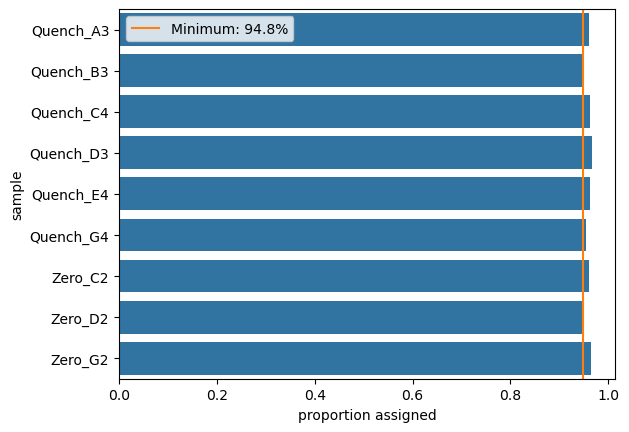

In [22]:
ax = sns.barplot(
    (
        df_data
        .assign(**{'proportion assigned': df_data['n_assigned'] / df_data['n_reads']})
        .drop_duplicates('sample')
    ),
    x='proportion assigned',
    y='sample',
    color='C0'
)
ax.axvline(
    x=(df_data['n_assigned'] / df_data['n_reads']).min(),
    label='Minimum: {:.1%}'.format((df_data['n_assigned'] / df_data['n_reads']).min()),
    color='C1'
)
ax.legend()
ax.figure.show()

In [23]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
n_total="$(unpigz -c "$DIR_PROC"/read_barcodes-*.txt.gz | wc -l)"
n_umis="$(
    unpigz -c "$DIR_PROC"/read_barcodes-*.txt.gz |
    grep -E -e 'RX:Z:[ATCGN-]*N' |
    wc -l
)"
echo "Number of UMIs by containing Ns: $n_umis out of $n_total total assigned reads"

Number of UMIs by containing Ns: 1144 out of 3190629 total assigned reads


## Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [barcode + UMI]
  - format: n/a
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `umi`
  - `value_vars`: `count`
- `df_barcode_counts`: counts per barcode
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: deduplicated counts per tag
  - format: long
  - `id_vars`: `sample`, `round`, `tag`, `deduplication`
  - `value_vars`: `count` (deduplicated)

In [24]:
path_umi_validation = os.path.join(DIR_RESULTS, 'umi_validation.csv')
path_tag_counts = os.path.join(DIR_RESULTS, 'tag_counts.csv')
path_barcode_counts = os.path.join(DIR_RESULTS, 'barcode_counts.csv')
path_umi_ecdf = os.path.join(DIR_RESULTS, 'umi_ecdf.csv')

In [25]:
reprocess = not all(os.path.exists(path) for path in [path_umi_validation, path_tag_counts, path_barcode_counts, path_umi_ecdf])
print('reprocess:', reprocess)

reprocess: True


In [38]:
regex_barcode = re.compile((
    r'\[OligoRC_(?P<Oligo>\d+)\]'
    r'\[LigEven\]'
    r'\[OddTop_(?P<Odd>\d+)\]'
    r'\[LigOdd\]'
    r'\[NYLigOddStgTop_(?P<Y>\d+)\]'
    r'\[Illumina\]'
    r'\[2Pbc\]'
    r'\[NYStgBot_(?P<Y_2>\d+)\]'
    r'\[Odd\]'
    r'\[OddBot_(?P<Odd_2>\d+)\]'
    r'\[Even\]'
    r'\[Oligo_(?P<Oligo_2>\d+)\]'
    r'\[Illumina\]'
    r'\[2Puni\]'
    r'\s+'
    r'RX:Z:(?P<umi>[ACGNT]*)-(?P<umi_2>[ACGNT]*)'
))

DTYPE_SAMPLE = pd.api.types.CategoricalDtype(categories=list(df_data['sample'].unique()))
DTYPE_COUNT_TYPE = pd.api.types.CategoricalDtype(categories=['raw', 'dedup'])
DTYPE_ROUNDS = pd.api.types.CategoricalDtype(categories=ROUNDS)

def count_barcodes(sample, regex, path_barcodes=None):
    '''
    From the read_barcodes file generated from a given sample and splitcode config,
    count the barcodes and UMIs, and tabulate in pandas DataFrames.

    Args
    - sample: str
        Sample name
    - regex: re.Pattern
        Regular expression pattern for barcode. Should contain named capture groups.
    
    Returns
    - df_barcode_counts: pandas.DataFrame
      - Only includes reads associated with 8 bp UMIs containing no Ns
      - Columns
        - Oligo, Odd, Y: np.uint8
        - count: np.int64
        - count_dedup: np.int64
        - sample: DTYPE_SAMPLE
    - df_umi_counts: pandas.DataFrame
      - Oligo, Odd, Y, Oligo_2, Odd_2, Y_2: np.uint8
      - umi: str
      - umi_2: str
      - count: np.int64
      - sample: DTYPE_SAMPLE
    - n_unmatched: int
        Number of reads whose barcodes did not match the provided regex.
    '''
    if path_barcodes is None:
        path_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    with gzip.open(path_barcodes, 'rt') as f:
        df_umi_counts, n_unmatched, unmatched = parse_barcodes.barcodes_to_df(f, regex)
    if len(df_umi_counts) > 0:
        df_umi_counts = (
            df_umi_counts
            .fillna(0)
            .astype({k: np.uint8 for k in ('Oligo', 'Odd', 'Y', 'Oligo_2', 'Odd_2', 'Y_2')})
            .groupby(list(df_umi_counts.columns), observed=True).size()
            .reset_index().rename(columns={0: 'count'})
        )
    else:
        df_umi_counts = pd.DataFrame([], columns=list(regex_barcode.groupindex.keys()) + ['count'])
    df_barcode_counts = (
        df_umi_counts
        .loc[
            (~df_umi_counts['umi'].str.contains('N')) & \
            (df_umi_counts['umi'].map(len) == 8) & \
            (df_umi_counts['umi'] == df_umi_counts['umi_2']) & \
            (df_umi_counts['Oligo'] == df_umi_counts['Oligo_2']) & \
            (df_umi_counts['Odd'] == df_umi_counts['Odd_2']) & \
            (df_umi_counts['Y'] == df_umi_counts['Y_2'])
        ]
        .drop(columns=['Oligo_2', 'Odd_2', 'Y_2', 'umi_2'])
        .groupby(ROUNDS, observed=True)["count"]
        .agg(["count", "sum"])
        .reset_index()
        .rename(columns={"count": "count_dedup", "sum": "count"})
    )
    df_barcode_counts['sample'] = pd.Series([sample] * len(df_barcode_counts), dtype=DTYPE_SAMPLE)
    df_umi_counts['sample'] = pd.Series([sample] * len(df_umi_counts), dtype=DTYPE_SAMPLE)
    return df_barcode_counts, df_umi_counts, n_unmatched, unmatched

In [39]:
def umi_df_to_validation(df, n_unmatched=None):
    '''
    Compute summary validation metrics from a UMI counts table (e.g., df_umi_counts).

    Args
    - df: pandas.DataFrame
        Columns must include 'umi' and 'count'. In this notebook, usually df_umi_counts.
    - n_unmatched: int or None
        Number of unmatched reads

    Returns: pandas.DataFrame
    - metric: str
        'R2 mismatch', 'N in UMI', or 'n_unmatched'
    - count_type: str
        'raw' or 'dedup'
    - count: int or None
    '''
    entries = []

    # reads with different R2 tag identified in read 1 versus read 2
    for r in (ROUNDS + ['umi']):
        mask_mismatch = df[r] != df[r + '_2']
        entries.append(dict(metric=f'{r} mismatch', count_type='raw', count=df.loc[mask_mismatch, 'count'].sum()))
        entries.append(dict(metric=f'{r} mismatch', count_type='dedup', count=mask_mismatch.sum()))

    # reads with UMIs containing Ns
    mask_ns = df['umi'].str.contains('N') | df['umi_2'].str.contains('N')
    entries.append(dict(metric='N in UMI', count_type='raw', count=df.loc[mask_ns, 'count'].sum()))
    entries.append(dict(metric='N in UMI', count_type='dedup', count=mask_ns.sum()))

    # reads unmatched
    entries.append(dict(metric='n_unmatched', count_type='raw', count=n_unmatched))
    return pd.DataFrame(entries)

In [40]:
if reprocess:
    df_umi_val_all = {}
    df_umi_ecdf = {}
    df_barcode_counts_all = {}

In [41]:
if reprocess:
    for sample in df_data['sample'].unique():
        df_barcode_counts, df_umi_counts, n_unmatched, unmatched = count_barcodes(sample, regex_barcode)
        if n_unmatched > 0:
            print((
                f'Sample {sample}: {n_unmatched} reads had barcodes [+ UMIs] that did not match '
                f'the regex. {min(3, n_unmatched)} / {n_unmatched} unmatched barcode-appended '
                'read names are printed below:'))
            for i in range(min(3, n_unmatched)):
                print('-', unmatched[i])
        df_umi_val_all[sample] = umi_df_to_validation(df_umi_counts, n_unmatched).assign(sample=sample)
        df_umi_ecdf[sample] = df_umi_counts['count'].value_counts()
        df_barcode_counts_all[sample] = df_barcode_counts.assign(sample=sample).astype(dict(sample=DTYPE_SAMPLE))

### Save / Load Processed Data

In [42]:
if reprocess:
    df_umi_val_all = pd.concat(df_umi_val_all.values(), axis=0, ignore_index=True)
    df_umi_val_all.to_csv(path_umi_validation, index=False)
else:
    df_umi_val_all = pd.read_csv(path_umi_validation, index_col=False)

In [43]:
if reprocess:
    df_barcode_counts_all = pd.concat(df_barcode_counts_all.values(), axis=0, ignore_index=True)
    df_barcode_counts_all.to_csv(path_barcode_counts, index=False)
else:
    df_barcode_counts_all = pd.read_csv(
        path_barcode_counts,
        dtype={
            'Oligo': np.uint8,
            'Odd': np.uint8,
            'Y': np.uint8,
            'count': np.int64,
            'count_dedup': np.int64,
            'sample': DTYPE_SAMPLE,
            'count_type': DTYPE_COUNT_TYPE,
        },
        index_col=False
    )

In [44]:
if reprocess:
    df_umi_ecdf_long = (
        pd.concat((pd.concat((pd.Series(0), s)) for s in df_umi_ecdf.values()), axis=1)
        .fillna(0)
        .astype(int)
        .sort_index()
        .reset_index(names='count')
        .melt(id_vars='count', var_name='sample', value_name='frequency')
        .groupby('sample', group_keys=False)
        .apply(lambda g: (
            g.sort_values('count')
            .pipe(lambda g2: g.assign(cumulative_prop=g['frequency'].cumsum() / g['frequency'].sum()))
        ))
        .pipe(lambda df: df.assign(sample=df['sample'].map(lambda i: list(df_umi_ecdf.keys())[i])))
    )
    df_umi_ecdf_long.to_csv(path_umi_ecdf, index=False)
else:
    df_umi_ecdf_long = pd.read_csv(path_umi_ecdf, index_col=False)

In [45]:
if reprocess:
    df_tag_counts = (
        df_barcode_counts_all
        .rename(columns=dict(count='raw', count_dedup='dedup'))
        .melt(
            id_vars=ROUNDS + ['sample'],
            var_name='count_type',
            value_name='count'
        )
        .melt(
            id_vars=['sample', 'count_type', 'count'],
            value_vars=ROUNDS,
            var_name='round',
            value_name='tag'
        )
        .groupby(['sample', 'count_type', 'round', 'tag'], observed=True)
        ['count'].sum()
        .reset_index()
        .astype(dict(round=DTYPE_ROUNDS))
    )
    df_tag_counts.to_csv(path_tag_counts, index=False)
else:
    df_tag_counts = pd.read_csv(
        path_tag_counts,
        index_col=False,
        dtype=dict(
            sample=DTYPE_SAMPLE,
            count_type=DTYPE_COUNT_TYPE,
            round=DTYPE_ROUNDS
        )
    )

# Validation

All assigned reads had read structures and UMIs matching expected regex.

In [46]:
df_umi_val_all.loc[df_umi_val_all['metric'] == 'n_unmatched', 'count'].unique()

array([0])

A negligible proportion of reads have different tags identified in read 1 vs. read 2, but there was a more sizeable proportion (up to ~1.75%) of reads with different UMIs identified in read 1 vs. read 2.

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


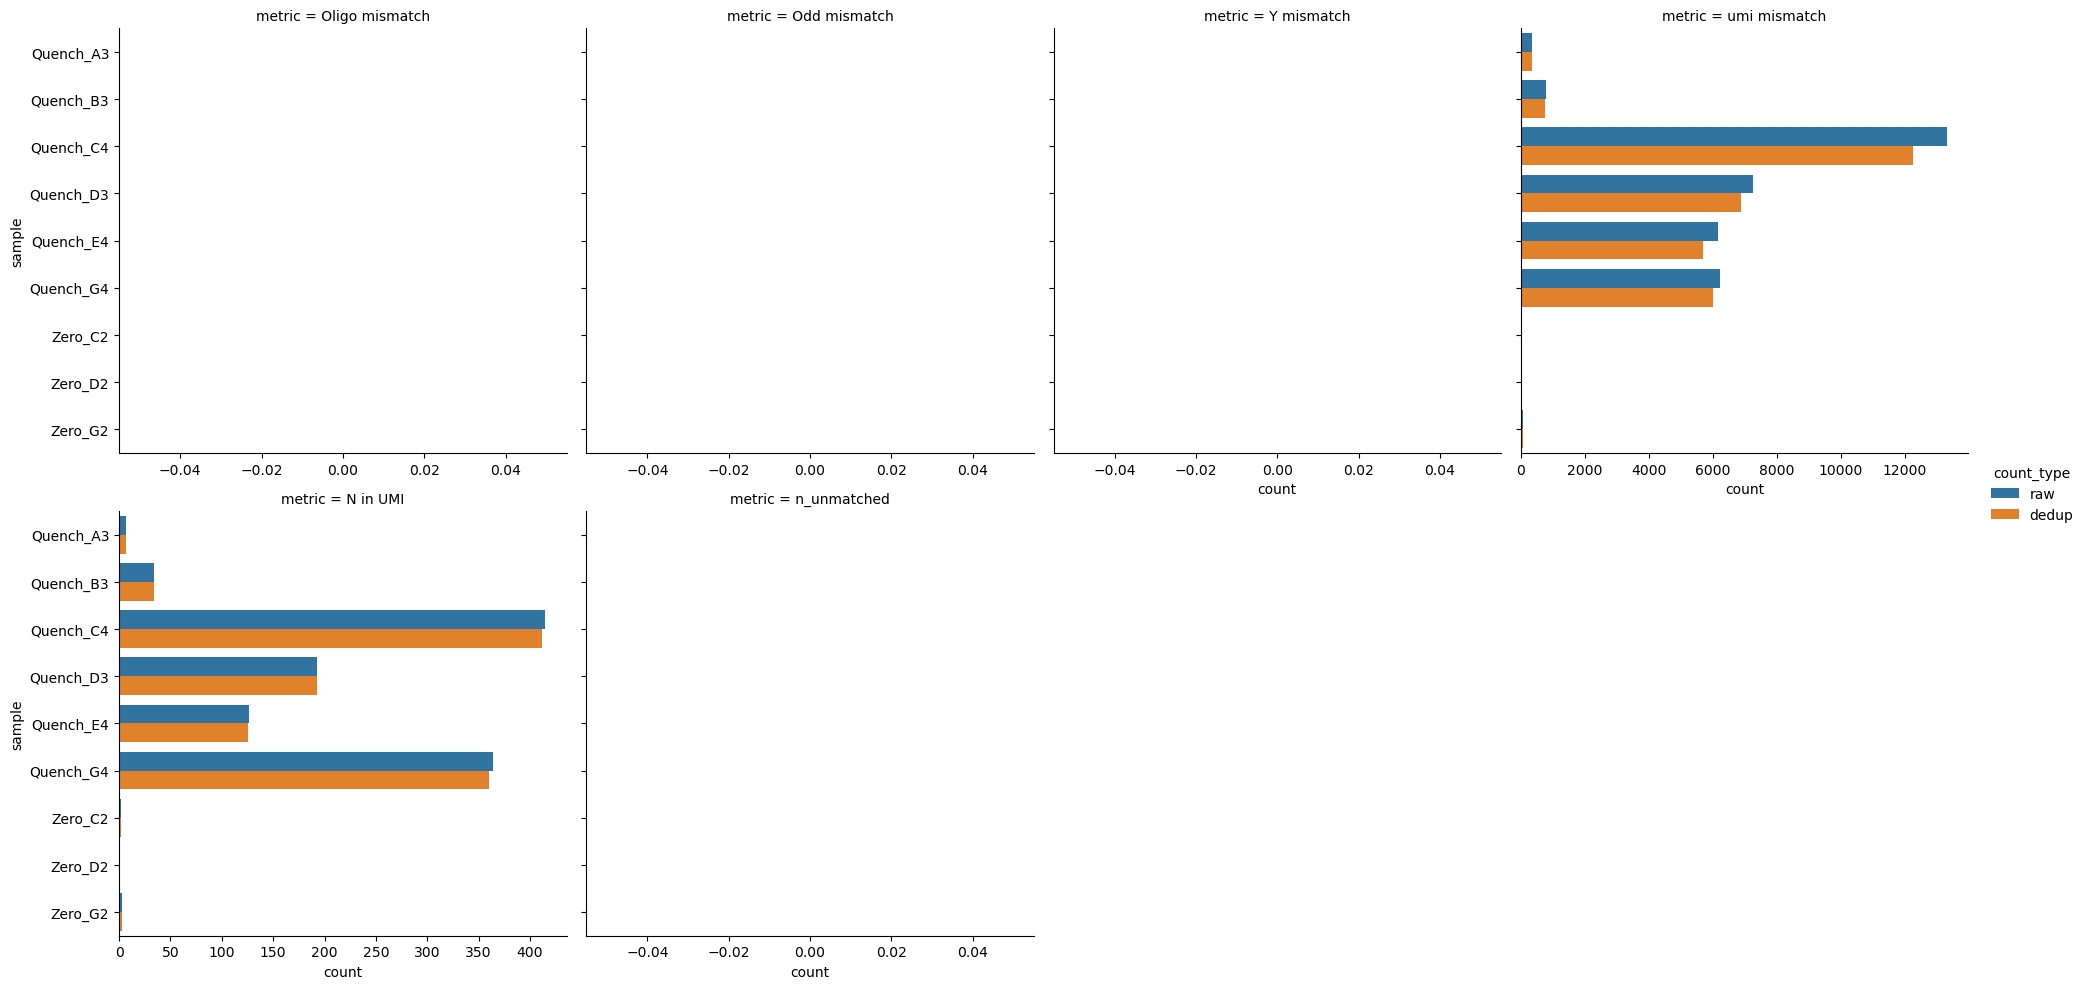

In [47]:
g = sns.catplot(
    kind='bar',
    data=df_umi_val_all,
    x='count',
    y='sample',
    hue='count_type',
    col='metric',
    col_wrap=4,
    sharex=False
)

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


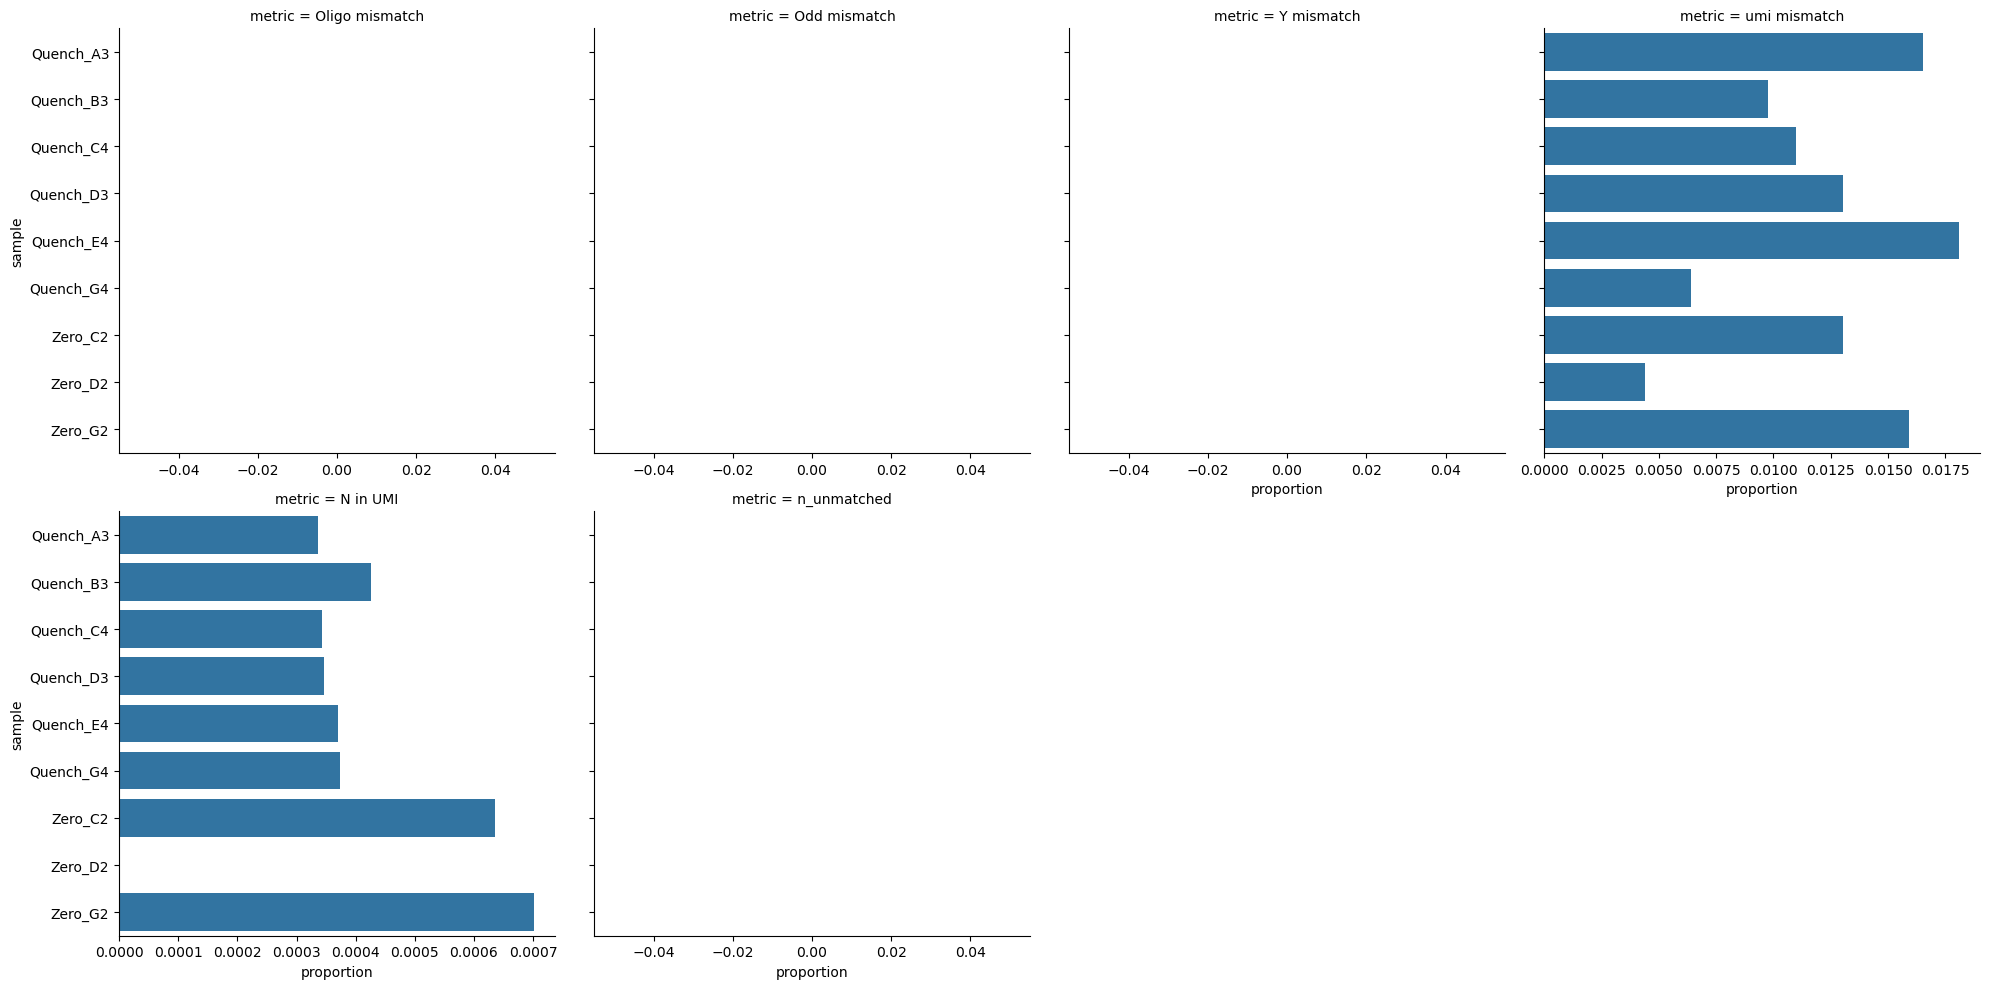

In [48]:
g = sns.catplot(
    kind='bar',
    data=(
        df_umi_val_all
        .loc[df_umi_val_all['count_type'] == 'raw']
        .drop(columns='count_type')
        .merge(df_data[['sample', 'n_assigned']].drop_duplicates('sample'))
        .pipe(lambda df: df.assign(proportion=df['count'] / df['n_assigned']))
        [['metric', 'sample', 'proportion']]
    ),
    x='proportion',
    y='sample',
    col='metric',
    col_wrap=4,
    color='C0',
    sharex=False
)

# Ligation QC

Tag counts faceted by sample and round, grouped (colored) by count type (raw or deduplicated)

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



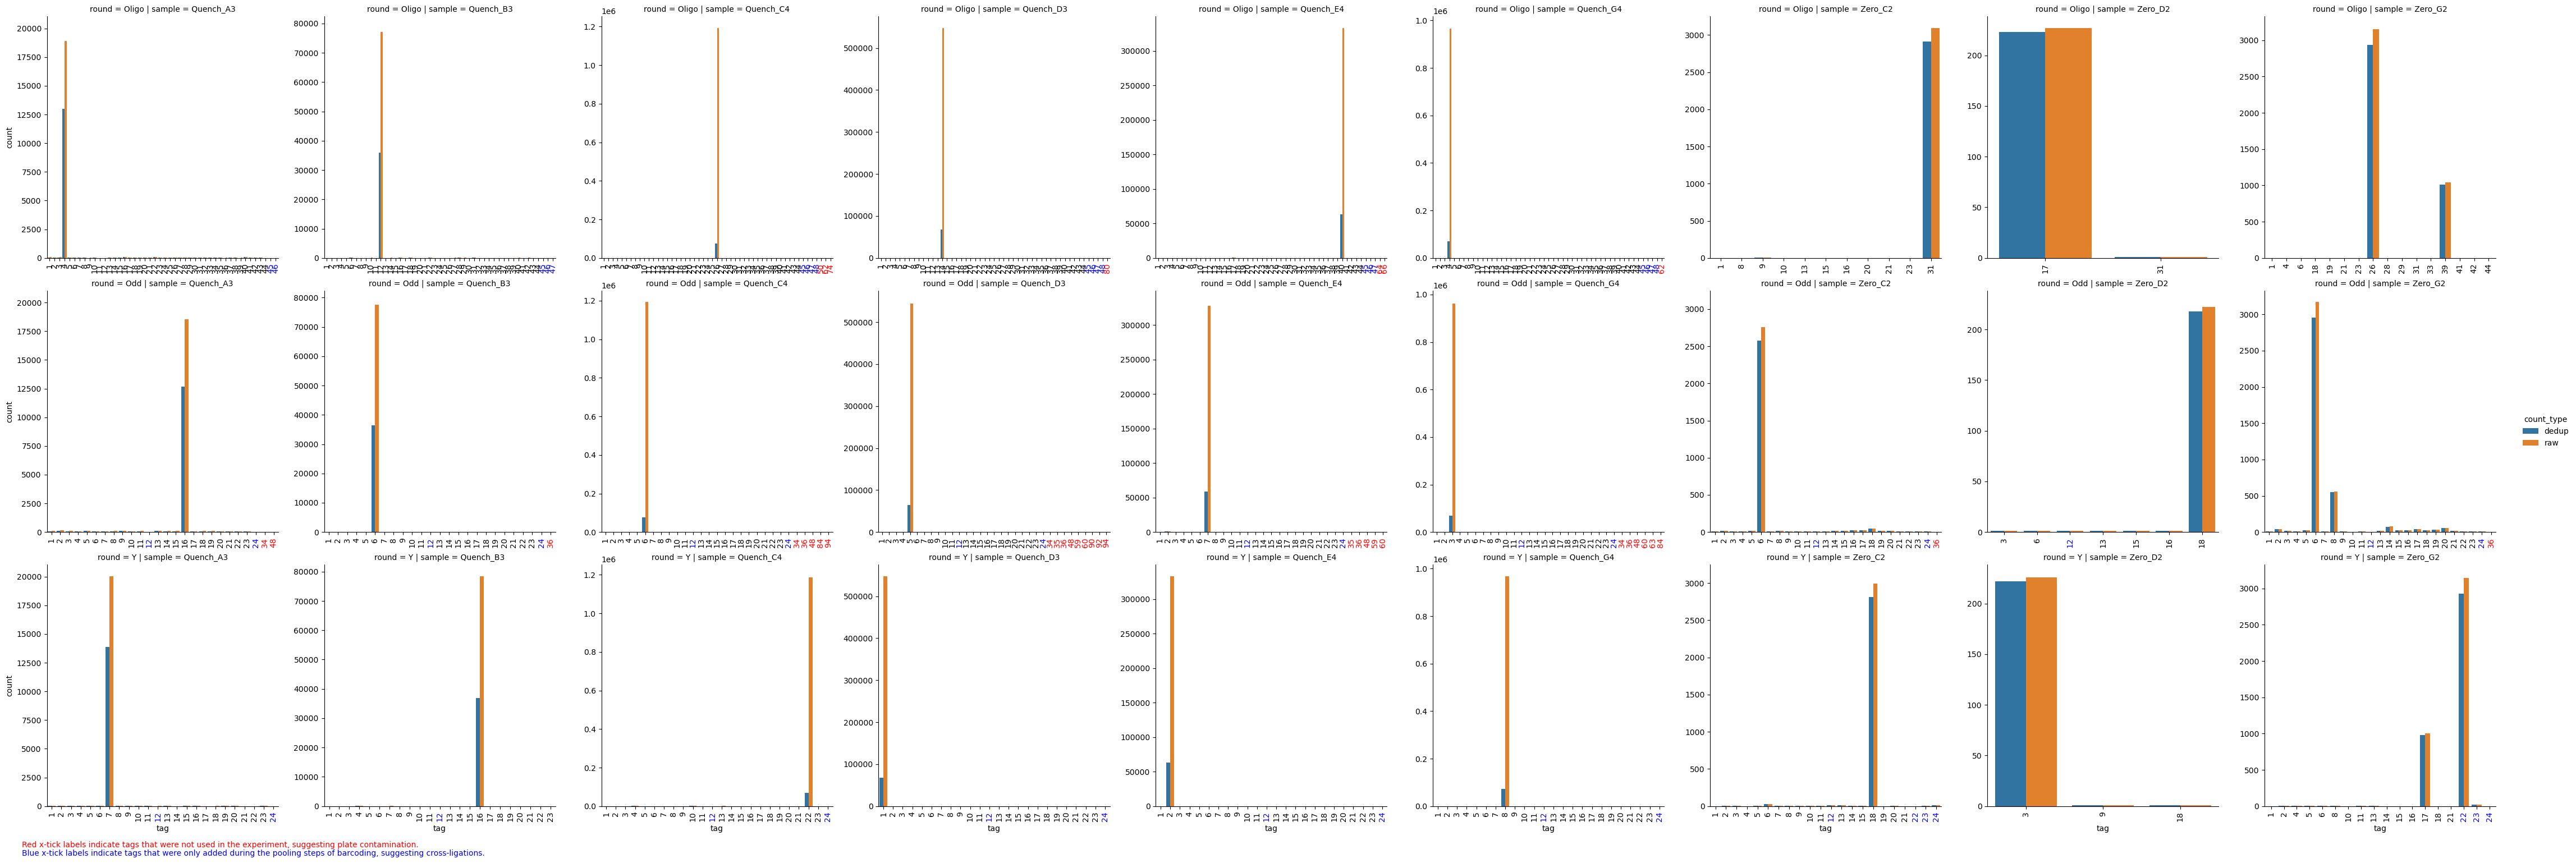

In [119]:
g = sns.catplot(
    df_tag_counts,
    kind='bar',
    x='tag',
    y='count',
    row='round',
    row_order=ROUNDS,
    hue='count_type',
    col='sample',
    sharex=False,
    sharey='col'
)

# red color for xticklabels corresponding to tags that were not used in the experiment
# - presence of red-colored tags suggests plate contamination
# blue color for xticklabels corresponding to tags that were only added during pooling
# - presence of blue-colored tags suggests low ligation efficiency
for (r, sample), ax in g.axes_dict.items():
    texts = ax.get_xticklabels()
    for text in ax.get_xticklabels():
        if r == 'Oligo':
            if int(text.get_text()) > 48:
                text.set_color('red')
            elif int(text.get_text()) > 44:
                text.set_color('blue')
        elif r == 'Odd':
            if int(text.get_text()) > 24:
                text.set_color('red')
            elif int(text.get_text()) in (12, 24):
                text.set_color('blue')
        elif r == 'Y':
            if int(text.get_text()) > 24:
                text.set_color('red')
            elif (sample.startswith('Quench') and int(text.get_text()) in (12, 24)) or \
                 (sample.startswith('Zero') and int(text.get_text()) in (12, 22, 23, 24)):
                text.set_color('blue')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize='xx-small' if len(tags) > 24 else None)

g.figure.text(
    0.01,
    -0.01,
    'Red x-tick labels indicate tags that were not used in the experiment, suggesting plate contamination.',
    color='red',
    ha='left'
)

g.figure.text(
    0.01,
    -0.02,
    'Blue x-tick labels indicate tags that were only added during the pooling steps of barcoding, suggesting cross-ligations.',
    color='blue',
    ha='left'
)

g.figure.savefig(
    os.path.join(DIR_RESULTS, 'tag_counts_by_sample.pdf'),
    bbox_inches='tight',
    dpi=300
)

Flow diagram (Sankey / parallel categories plot)

In [50]:
for sample in df_barcode_counts_all['sample'].unique():
    mask_sample = (df_barcode_counts_all['sample'] == sample)
    fig = go.Figure(go.Parcats(
        dimensions=[
            {
                'label': r,
                'values': df_barcode_counts_all.loc[mask_sample, r],
                'categoryorder': 'category ascending'
            } for r in ROUNDS
        ],
        counts=df_barcode_counts_all.loc[mask_sample, 'count_dedup']))
    fig.update_layout(
        title_text=f'Sample: {sample}',
        width=600,
        height=600,
        margin=dict(l=10, b=10, t=50, r=10)
    )
    # fig.show()
    fig.write_image(os.path.join(DIR_RESULTS, f'parcats_{sample}.pdf'))

Count (or proportion of total count) per barcode (akin to scSPRITE Figure 1C)

In [54]:
fig = px.line(
    (
        df_barcode_counts_all
        .groupby('sample', group_keys=False)
        .apply(lambda g:
           g.assign(
               rank=np.argsort(np.argsort(-g['count_dedup'])),
               proportion=g['count_dedup'] / g['count_dedup'].sum()
           ).pipe(lambda g2: g2.loc[g2['rank'] < 6]))
        .reset_index()
        .melt(id_vars=['sample', 'rank'], value_vars=['count', 'proportion'], var_name='metric')
        .sort_values(['sample', 'rank'])
    ),
    x='rank',
    y='value',
    color='sample',
    facet_row='metric',
    markers=True,
    # category_orders=dict(well=sorted(df_data['sample'].unique())),
    # color_discrete_sequence=sns.color_palette('cividis', n_colors=len(df_data['sample'].unique())).as_hex(),
    labels={'rank': 'barcode rank'}
)
fig.update_yaxes(
    matches=None,
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_xaxes(
    gridcolor='lightgray',
    linecolor='black'
)
fig.update_layout(
    margin=dict(l=0, b=10, t=50, r=10),
    height=600,
    width=800,
    plot_bgcolor='#fff'
)
fig.write_image(os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank.png'), scale=2)
fig.show()

# Sequencing Depth and Duplicates

## UMI distribution

In [55]:
umi_distribution = (
    df_umi_ecdf_long.groupby('count')['frequency'].sum()
    .pipe(lambda s: s/s.sum()).rename('proportion')
)
display(umi_distribution)
print('mean UMI count: {:.3f}'.format((np.array(umi_distribution.index) * umi_distribution).sum()))

count
0      0.000000
1      0.309571
2      0.095604
3      0.068772
4      0.054942
         ...   
292    0.000003
304    0.000003
319    0.000003
320    0.000003
391    0.000003
Name: proportion, Length: 218, dtype: float64

mean UMI count: 8.466


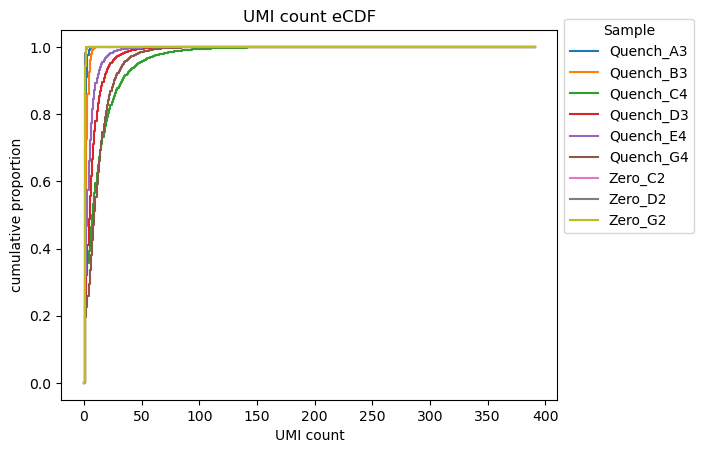

In [61]:
fig, ax = plt.subplots()
for sample in sorted(df_umi_ecdf_long['sample'].unique()):
    mask = (df_umi_ecdf_long['sample'] == sample)
    ax.step(
        df_umi_ecdf_long.loc[mask, 'count'],
        df_umi_ecdf_long.loc[mask, 'cumulative_prop'],
        where='post',
        label=sample
    )
ax.legend(title='Sample', loc='upper left', bbox_to_anchor=(1, 1.05))
ax.set(
    xlabel='UMI count',
    ylabel='cumulative proportion',
    title='UMI count eCDF',
    # xticks=range(df_umi_ecdf_long['count'].max() + 1)
)
fig.show()

## Estimate library complexity

Note: The current method of library complexity estimation assumes that the number of available UMIs far exceeds the number of unique molecules, and therefore underestimates the true library complexity. A better model would account for the possibility of real UMI collisions, and as a consequence of PCR duplicates/sequencing.

In [62]:
def estimate_library_complexity(count_total, count_dedup, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md

    Generative model: Poisson sampling (i.e., with replacement) count_total reads from
    M unique molecules, such that count_dedup molecules were sampled at least once. Solve
    for M.
    '''
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: (M * (1 - np.exp(-count_total/M)) - count_dedup)**2,
      bracket=(count_dedup, count_total*1e5)
    )
    assert res.fun < max_err
    return res.x

In [65]:
umi_complexity = 4**8
print('Maximum UMI complexity:', umi_complexity)

Maximum UMI complexity: 65536


Calculate the complexity of all barcodes in each sample.

In [66]:
complexity_umi_all = df_barcode_counts_all.groupby('sample')[['count', 'count_dedup']].sum().apply(
    lambda s: estimate_library_complexity(s['count'], s['count_dedup']),
    axis=1)

Calculate the complexity of the predominant barcode in each sample.

In [67]:
complexity_umi_top = (
    df_barcode_counts_all
    .groupby("sample", group_keys=True)
    .apply(lambda group: group.iloc[group["count"].argmax()][["count", "count_dedup"]])
    .apply(lambda s: estimate_library_complexity(s['count'], s['count_dedup']), axis=1)
)

### Plot

In [84]:
df_data = df_data.merge(
    pd.concat(
        (
            complexity_umi_top.rename('complexity_umi_est_top'),
            complexity_umi_all.rename('complexity_umi_est_all'),
            df_barcode_counts_all.groupby('sample') ['count_dedup'].sum()
        ),
        axis=1,
    ).reset_index(),
    how='left'
)

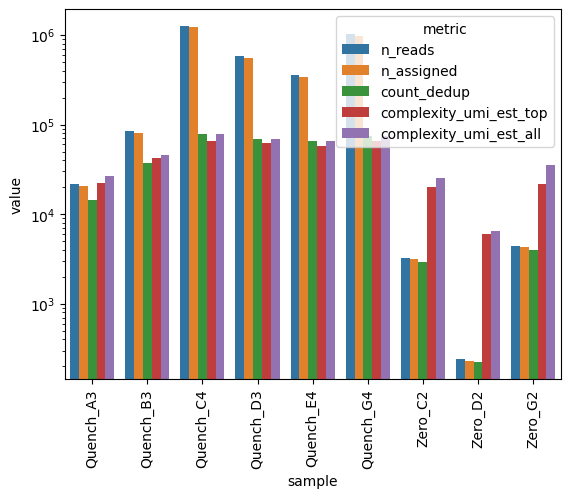

In [87]:
ax = sns.barplot(
    (
        df_data
        [['sample', 'n_reads', 'n_assigned', 'count_dedup', 'complexity_umi_est_top', 'complexity_umi_est_all']]
        .drop_duplicates()
        .melt(id_vars='sample')
        .rename(columns={'variable': 'metric'})
    ),
    x='sample',
    y='value',
    hue='metric'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yscale('log')
ax.figure.show()

## Estimated coverage and duplication rate

"Coverage" = proportion of physical molecules that were sequenced and assigned.
- Assume sampling `count_dedup` molecules from `complexity_umi_est_all` molecules.

In [88]:
(
    df_data[['sample', 'count_dedup', 'complexity_umi_est_all']]
    .drop_duplicates()
    .set_index('sample')
    .apply(
        lambda s: 1 - scipy.stats.binom.pmf(0, n=s['count_dedup'], p=1/s['complexity_umi_est_all']),
        axis=1
    )
    .rename('coverage')
)

sample
Quench_A3    0.416941
Quench_B3    0.561668
Quench_C4    0.632123
Quench_D3    0.631999
Quench_E4    0.629961
Quench_G4    0.632122
Zero_C2      0.107990
Zero_D2      0.034283
Zero_G2      0.106238
Name: coverage, dtype: float64

Duplication rate = proportion of sequenced and assigned reads that are duplicates

In [70]:
(
    df_barcode_counts_all[['sample', 'count', 'count_dedup']]
    .groupby(['sample']).sum()
    .pipe(lambda df: df.assign(duplication_rate=(df['count'] - df['count_dedup'])/df['count']))
)

,count,count_dedup,duplication_rate
sample,,,
Quench_A3,20428,14213,0.304239
Quench_B3,79032,37426,0.526445
Quench_C4,1195892,77881,0.934876
Quench_D3,548767,68633,0.874932
Quench_E4,334766,64753,0.806572
Quench_G4,970005,74802,0.922885
Zero_C2,3105,2924,0.058293
Zero_D2,228,224,0.017544
Zero_G2,4208,3967,0.057272
